In [1]:
import keras
import seaborn as sns
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils.image_utils import load_img
# import cv2
import os
import pickle
from sklearn.model_selection import train_test_split
# from pandas import DataFrame
import efficientnet.tfkeras as efn

# from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Input
# from tensorflow.keras import layers
# from tensorflow.keras.optimizers import Adam, RMSprop, Adamax, SGD
# import efficientnet.tfkeras as efn
# from keras.models import load_model
# from tensorflow.keras import callbacks
# from tensorflow.keras.callbacks import ReduceLROnPlateau

import itertools
from sklearn import metrics
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df_train = pd.read_csv('DR_Fundus/train_edit.csv')
df_train['file_name'] = df_train["id_code"].apply(lambda x: x + ".png")
df_train['diagnosis'] = df_train['diagnosis'].astype(str)

# data_train,data_val = train_test_split(df_train,test_size = 0.25)
# print(data_train.shape,data_val.shape)
file = open('data_train_edit2', 'rb')
data_train = pickle.load(file)
file.close()

file = open('data_val_edit2', 'rb')
data_val = pickle.load(file)
file.close()

file = open('data_test_edit2', 'rb')
data_test = pickle.load(file)
file.close()

print(data_train.shape,data_val.shape, data_test.shape)

(2608, 4) (870, 4) (184, 4)


In [3]:
train_datagen = ImageDataGenerator(
                                rotation_range = 90,
                                zoom_range=0.2,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True)
    
train_generator = train_datagen.flow_from_dataframe(dataframe=data_train,
                                                  directory="DR_Fundus/Training_GB",
                                                  x_col="file_name",
                                                  y_col="diagnosis",
                                                  batch_size=16,
                                                  class_mode="categorical",
                                                  target_size=(224, 224),
                                                  shuffle=True,
                                                  subset='training')

test_datagen = ImageDataGenerator()

val_generator = train_datagen.flow_from_dataframe(dataframe=data_val,
                                                  directory = "DR_Fundus/Training_GB",
                                                  x_col="file_name",
                                                  y_col="diagnosis",
                                                  target_size=(224, 224),
                                                  batch_size=16,
                                                  shuffle=False,
                                                  class_mode="categorical")

test_generator = test_datagen.flow_from_dataframe(dataframe=data_test,
                                                  directory = "DR_Fundus/Training_GB",
                                                  x_col="file_name",
                                                  y_col="diagnosis",
                                                  target_size=(224, 224),
                                                  batch_size=16,
                                                  shuffle=False,
                                                  class_mode="categorical")                                            

print(len(data_train['diagnosis']))

Found 2608 validated image filenames belonging to 3 classes.
Found 870 validated image filenames belonging to 3 classes.
Found 184 validated image filenames belonging to 3 classes.
2608


In [4]:
y_train = data_train['diagnosis']
num_samples = len(y_train)
num_classes = np.unique(y_train).size
print(num_classes)

# Calculate the number of samples in each class
class_samples = np.bincount(y_train)
print(class_samples)

# Calculate the class weights using the formula
class_weights = num_samples / (num_classes * class_samples)
class_weights_dict = dict(enumerate(class_weights))
# Print the class weights
print(class_weights_dict)

3
[1274 1132  202]
{0: 0.6823652537938252, 1: 0.767962308598351, 2: 4.303630363036303}


In [5]:
def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
	return focal_loss_fixed

In [6]:
from tensorflow.keras.applications import EfficientNetB0
model = tf.keras.Sequential([
         EfficientNetB0(
            input_shape=(224,224, 3),
            weights='imagenet',
            include_top=False
        ),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
Adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=Adam, loss=focal_loss(),  metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
def scheduler(epoch, lr):
    if (epoch < 10):
        return lr
    else:
        return lr * tf.math.exp(-0.1)

LRS = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

RLROP = ReduceLROnPlateau(monitor='val_loss', mode='auto',factor=0.5, patience=2, 
                          min_lr=0.00001, cooldown=2, verbose=1)
ES = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

In [8]:
import time
from PIL import Image
import scipy


start = time.time()
history = model.fit(train_generator,
                    validation_data=val_generator,
                    callbacks=[LRS,RLROP],
                    epochs=50,
                    class_weight=class_weights_dict,
                    verbose=1)
stop = time.time()


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50
163/163 [==============================] - 44s 200ms/step - loss: 0.0453 - accuracy: 0.7753 - val_loss: 0.0311 - val_accuracy: 0.8218 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/50
163/163 [==============================] - 31s 191ms/step - loss: 0.0337 - accuracy: 0.8359 - val_loss: 0.0280 - val_accuracy: 0.8793 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/50
163/163 [==============================] - 31s 191ms/step - loss: 0.0320 - accuracy: 0.8489 - val_loss: 0.0244 - val_accuracy: 0.8805 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/50
163/163 [==============================] - 31s 192ms/step - loss: 0.0308 - accuracy: 0.8597 - val_loss: 0.0212 - val_accuracy: 0.8943 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning

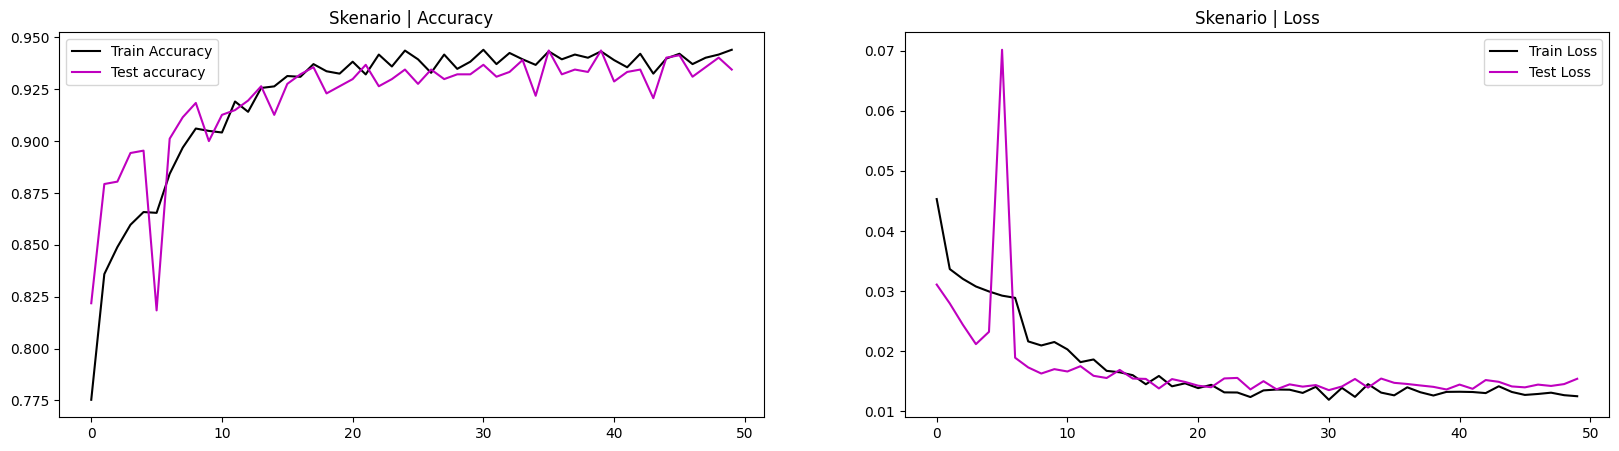

In [9]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Skenario | Accuracy')
ax1.legend(['Train Accuracy','Test accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Skenario | Loss')
ax2.legend(['Train Loss','Test Loss'])

# plt.savefig("Test.svg")
plt.show()

In [10]:
result_train = model.evaluate(train_generator)
print('\n', 'Hasil Akurasi Train = {:.4f}'.format(result_train[1]),
      " Hasil Loss Train = {:.4f}".format(result_train[0]))

result_val = model.evaluate(val_generator)
print('\n', 'Hasil Akurasi Val =  {:.4f}'.format(result_val[1]),
      " Hasil Loss Val = {:.4f}".format(result_val[0]))

# result_test = model.evaluate_generator(test_generator, 733  // 33)
# print('\n', 'Hasil Akurasi Test =  {:.4f}'.format(result_test[1]),
#       " Hasil Loss Test = {:.4f}".format(result_test[0]))

163/163 [==============================] - 21s 127ms/step - loss: 0.0106 - accuracy: 0.9463

 Hasil Akurasi Train = 0.9463  Hasil Loss Train = 0.0106
55/55 [==============================] - 7s 124ms/step - loss: 0.0150 - accuracy: 0.9276

 Hasil Akurasi Val =  0.9276  Hasil Loss Val = 0.0150


In [11]:
res = model.evaluate(test_generator)

12/12 [==============================] - 4s 341ms/step - loss: 0.0190 - accuracy: 0.9185


In [12]:
batch_size = 16  
steps = int(np.ceil(len(data_test) / batch_size))
test_generator.reset()
test_preds = model.predict_generator(test_generator, steps=steps, verbose=1)
test_labels = np.argmax(test_preds, axis=1)
print('Confusion Matrix: \n')
print(confusion_matrix(data_test['diagnosis'].astype(int), test_labels))

C:\Users\Alvin\AppData\Local\Temp\ipykernel_5760\2372437246.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_preds = model.predict_generator(test_generator, steps=steps, verbose=1)


12/12 [==============================] - 2s 37ms/step
Confusion Matrix: 

[[83  2  0]
 [ 3 71  3]
 [ 1  6 15]]


In [13]:
print('Classification Report : \n')
target_names = ['0', '1', '2']
print(classification_report(list(data_test['diagnosis'].astype(int)), test_labels, target_names=target_names))

print('Confusion Matrix : \n')
print(confusion_matrix(list(data_test['diagnosis'].astype(int)), test_labels))

Classification Report : 

              precision    recall  f1-score   support

           0       0.95      0.98      0.97        85
           1       0.90      0.92      0.91        77
           2       0.83      0.68      0.75        22

    accuracy                           0.92       184
   macro avg       0.90      0.86      0.88       184
weighted avg       0.92      0.92      0.92       184

Confusion Matrix : 

[[83  2  0]
 [ 3 71  3]
 [ 1  6 15]]


In [14]:
from sklearn.metrics import  precision_recall_curve, auc, roc_curve
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score

y_pred = data_test['diagnosis'].astype(int)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_pred, test_labels)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_pred, test_labels, average='macro')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_pred, test_labels, average='macro')
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_pred, test_labels, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.918478
Precision: 0.895363
Recall: 0.860122
F1 score: 0.875124


In [15]:
# precision tp / (tp + fp)
precision = precision_score(y_pred, test_labels, average='weighted')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_pred, test_labels, average='weighted')
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_pred, test_labels, average='weighted')
print('F1 score: %f' % f1)

Precision: 0.916456
Recall: 0.918478
F1 score: 0.916438


In [16]:
# precision tp / (tp + fp)
precision = precision_score(y_pred, test_labels, average='micro')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_pred, test_labels, average='micro')
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_pred, test_labels, average='micro')
print('F1 score: %f' % f1)

Precision: 0.918478
Recall: 0.918478
F1 score: 0.918478


In [17]:
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g',cmap="YlGnBu")
    plt.show()

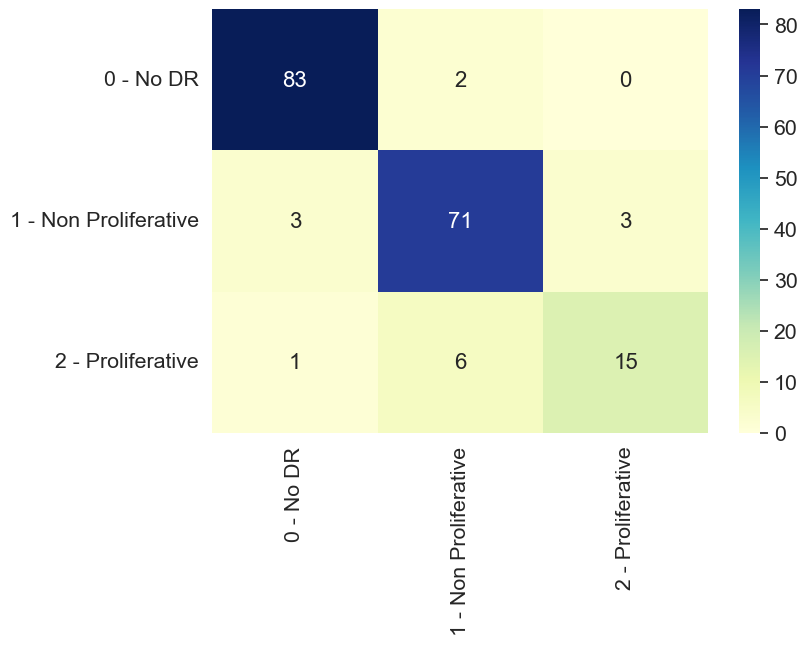

In [18]:
labels = ['0 - No DR', '1 - Non Proliferative', '2 - Proliferative']
plot_conf_matrix(list(data_test['diagnosis'].astype(int)),test_labels,labels)

In [19]:
# model.save('Model_EffnetB0_3class.h5')

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open('Model_effnetb0_3class.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Alvin\AppData\Local\Temp\tmptfb1i00q\assets


INFO:tensorflow:Assets written to: C:\Users\Alvin\AppData\Local\Temp\tmptfb1i00q\assets


23392716

In [21]:
train_dir = os.path.join('DR_Fundus/Training_GB/')
data_test['file_name'] = data_test["id_code"].apply(lambda x: x + ".png")
data_test['file_path'] = data_test['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))

x=0
for i in range(184):
    image = Image.open(data_test.file_path.iloc[i])
    input = np.array(image)
    input = np.expand_dims(input,axis=0)

    predictions = model.predict(input)
    print(np.argmax(predictions))
    if(np.argmax(predictions).astype(str)==data_test.iloc[i]['diagnosis']):
        x=x+1

print(x)

1/1 [==============================] - 2s 2s/step
0
1/1 [==============================] - 0s 29ms/step
1
1/1 [==============================] - 0s 27ms/step
0
1/1 [==============================] - 0s 27ms/step
1
1/1 [==============================] - 0s 27ms/step
2
1/1 [==============================] - 0s 30ms/step
0
1/1 [==============================] - 0s 26ms/step
0
1/1 [==============================] - 0s 34ms/step
0
1/1 [==============================] - 0s 29ms/step
0
1/1 [==============================] - 0s 35ms/step
0
1/1 [==============================] - 0s 33ms/step
0
1/1 [==============================] - 0s 34ms/step
0
1/1 [==============================] - 0s 28ms/step
0
1/1 [==============================] - 0s 33ms/step
1
1/1 [==============================] - 0s 33ms/step
1
1/1 [==============================] - 0s 33ms/step
1
1/1 [==============================] - 0s 35ms/step
1
1/1 [==============================] - 0s 29ms/step
0
1/1 [=========================